In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812364 sha256=85729cd03d09a8be1970926e7f007070acd915eb5bfa3c2063fedb5a1bb4c186
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, LinearSVC
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# Initialize Spark session
spark = SparkSession.builder \
    .appName("ML") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/18 17:51:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Read the CSV file
df = spark.read.csv("/kaggle/input/mlmodel/big_processed_data.csv", header=True, inferSchema=True)

# Show the first few rows
df.show(5)

24/09/18 17:51:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+------+--------------------+--------+-------------------+--------------------+--------------------+------------------+-------------------------+-----------------------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|                 amt|gender|            city_pop|is_fraud|                age|          trans_hour|category_food&health|category_household|category_shopping&grocery|category_transportation|state_AL|state_AR|state_AZ|state_CA|state_CO|state_CT|state_DC|state_DE|state_FL|state_GA|state_HI|state_IA|state_ID|state_IL|state_IN|state_KS|state_KY|state_LA|state_M

In [4]:
# Group by the 'is_fraud' column and count occurrences of each value
df.groupBy('is_fraud').count().show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       1|   9651|
|       0|1842743|
+--------+-------+



In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
# Step 1: Oversample the minority class (is_fraud = 1)
# Separate the majority and minority classes
from pyspark.sql.functions import col

# Separate the majority and minority classes
majority_class = df.filter(col("is_fraud") == 0)
minority_class = df.filter(col("is_fraud") == 1)

# Oversample the minority class by replicating rows
oversample_factor = int(majority_class.count() / minority_class.count())

# Use union to concatenate the minority class multiple times
oversampled_minority = minority_class
for _ in range(oversample_factor - 1):
    oversampled_minority = oversampled_minority.union(minority_class)

# Combine oversampled minority class and majority class
balanced_df = majority_class.union(oversampled_minority)

# Verify the new class distribution
balanced_df.groupBy("is_fraud").count().show()


+--------+-------+
|is_fraud|  count|
+--------+-------+
|       0|1842743|
|       1|1833690|
+--------+-------+



In [7]:
from pyspark.ml.feature import VectorAssembler

# Select features and assemble them into a single vector
feature_columns = [col for col in balanced_df.columns if col != 'is_fraud']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_df = assembler.transform(balanced_df)

In [8]:
# from pyspark.ml.feature import StandardScaler

# # Apply Standard Scaling to normalize the features
# scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
# scaler_model = scaler.fit(assembled_df)
# scaled_df = scaler_model.transform(assembled_df)


In [9]:
# Split the data into training and test sets (80% training, 20% test)
train_df, test_df = assembled_df.randomSplit([0.8, 0.2], seed=42)


In [10]:
from pyspark.ml.classification import LogisticRegression

# Initialize Logistic Regression model
lr = LogisticRegression(featuresCol="features", labelCol="is_fraud")

# Train the model
lr_model = lr.fit(train_df)


24/09/18 18:01:54 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 18:24:25 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 18:24:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/09/18 18:24:29 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 18:49:18 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 18:49:20 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 18:50:09 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 18:50:11 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 18:50:52 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 18:50:53 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 18:51:40 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 18:51:42 WARN DAGSchedul

In [11]:
# Make predictions on the test data
predictions = lr_model.transform(test_df)

In [12]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="is_fraud", metricName="areaUnderROC")

# Evaluate the model
roc_auc = evaluator.evaluate(predictions)
print(f"ROC-AUC: {roc_auc}")

# Show some of the predictions
predictions.select("is_fraud", "prediction", "probability").show(5)


24/09/18 19:15:11 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


ROC-AUC: 0.8834612149615567


24/09/18 19:40:56 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


+--------+----------+--------------------+
|is_fraud|prediction|         probability|
+--------+----------+--------------------+
|       0|       0.0|[0.81047136757113...|
|       0|       0.0|[0.82455154027546...|
|       0|       0.0|[0.86133935415305...|
|       0|       0.0|[0.89303305394269...|
|       0|       0.0|[0.85059150521464...|
+--------+----------+--------------------+
only showing top 5 rows



In [13]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make predictions on the test data
predictions = lr_model.transform(test_df)

# Create evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="precisionByLabel")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="recallByLabel")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="fMeasureByLabel")

# Evaluate metrics
accuracy = accuracy_evaluator.evaluate(predictions)
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")


24/09/18 19:41:18 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 20:05:34 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 20:29:57 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 20:54:20 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


Accuracy: 0.8459190565430041
Precision: 0.7949214870115171
Recall: 0.9332937386097371
F1-Score: 0.8585681175763231


In [14]:
# Convert predictions to Pandas DataFrame
preds_pd = predictions.select("is_fraud", "prediction", "probability").toPandas()

# Extract probability of class 1 (fraud)
preds_pd['probability_fraud'] = preds_pd['probability'].apply(lambda x: x[1])

# Show the Pandas DataFrame to verify
print(preds_pd.head())


24/09/18 21:19:00 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


   is_fraud  prediction                                probability  \
0         0         0.0  [0.8104713675711396, 0.18952863242886042]   
1         0         0.0  [0.8245515402754698, 0.17544845972453016]   
2         0         0.0  [0.8613393541530588, 0.13866064584694116]   
3         0         0.0  [0.8930330539426958, 0.10696694605730417]   
4         0         0.0  [0.8505915052146498, 0.14940849478535023]   

   probability_fraud  
0           0.189529  
1           0.175448  
2           0.138661  
3           0.106967  
4           0.149408  


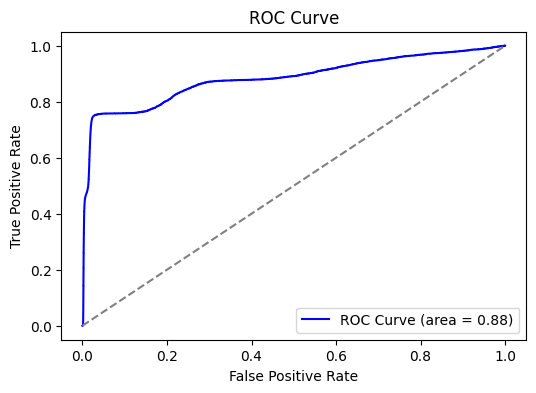

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve

# Compute false positive rate (fpr), true positive rate (tpr) and thresholds
fpr, tpr, thresholds = roc_curve(preds_pd['is_fraud'], preds_pd['probability_fraud'])

# Plot ROC Curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()


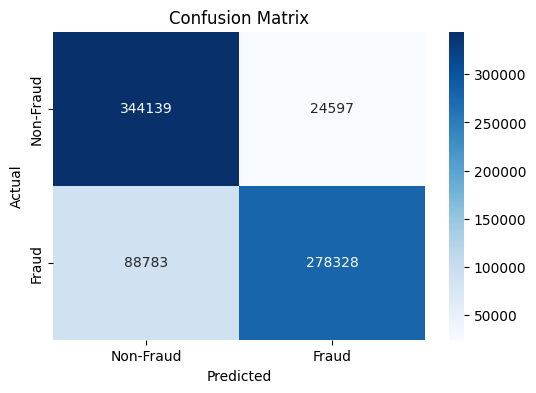

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(preds_pd['is_fraud'], preds_pd['prediction'])

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


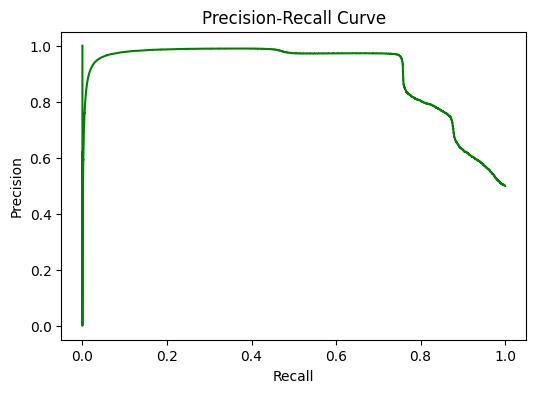

In [17]:
from sklearn.metrics import precision_recall_curve

# Compute precision and recall
precision, recall, thresholds_pr = precision_recall_curve(preds_pd['is_fraud'], preds_pd['probability_fraud'])

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='green')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make predictions on the test data
predictions = lr_model.transform(test_df)

# Create evaluators for precision, recall, and f1 for both classes (0 and 1)
precision_evaluator_0 = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="precisionByLabel", metricLabel=0.0)
recall_evaluator_0 = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="recallByLabel", metricLabel=0.0)
f1_evaluator_0 = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="fMeasureByLabel", metricLabel=0.0)

precision_evaluator_1 = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="precisionByLabel", metricLabel=1.0)
recall_evaluator_1 = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="recallByLabel", metricLabel=1.0)
f1_evaluator_1 = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="fMeasureByLabel", metricLabel=1.0)

# Calculate metrics for both classes
precision_0 = precision_evaluator_0.evaluate(predictions)
recall_0 = recall_evaluator_0.evaluate(predictions)
f1_0 = f1_evaluator_0.evaluate(predictions)

precision_1 = precision_evaluator_1.evaluate(predictions)
recall_1 = recall_evaluator_1.evaluate(predictions)
f1_1 = f1_evaluator_1.evaluate(predictions)

# Calculate accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="is_fraud", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)

# Print classification report
print("Classification Report:")
print(f"Class 0 (Not Fraud):\n  Precision: {precision_0:.4f}\n  Recall: {recall_0:.4f}\n  F1-Score: {f1_0:.4f}")
print(f"Class 1 (Fraud):\n  Precision: {precision_1:.4f}\n  Recall: {recall_1:.4f}\n  F1-Score: {f1_1:.4f}")
print(f"\nOverall Accuracy: {accuracy:.4f}")


24/09/18 21:45:28 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 22:09:51 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 22:34:19 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 22:59:03 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 23:24:11 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/18 23:49:13 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/09/19 00:14:04 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


Classification Report:
Class 0 (Not Fraud):
  Precision: 0.7949
  Recall: 0.9333
  F1-Score: 0.8586
Class 1 (Fraud):
  Precision: 0.9188
  Recall: 0.7582
  F1-Score: 0.8308

Overall Accuracy: 0.8459
